In [1]:
# ============================================================================
# FIX: LOAD DATA DARI CHECKPOINT TAHAP 1
# ============================================================================

import pandas as pd
import os

CHECKPOINT_PATH = "../data/processed/00_raw_loaded.csv"

if not os.path.exists(CHECKPOINT_PATH):
    raise FileNotFoundError(
        "❌ File checkpoint TAHAP 1 tidak ditemukan!\n"
        "Pastikan TAHAP 1 sudah dijalankan sampai selesai."
    )

df = pd.read_csv(CHECKPOINT_PATH)
print(f"✅ Dataset berhasil dimuat ulang: {df.shape[0]} baris × {df.shape[1]} kolom")

# Deteksi ulang kolom target (AMAN)
possible_targets = [
    'GRADE', 'Grade', 'grade', 
    'OUTPUT', 'Output', 'output',
    'FINAL_GRADE', 'final_grade',
    'CLASS', 'Class', 'class'
]

target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    raise ValueError("❌ Kolom target tidak ditemukan!")

print(f"🎯 Target column terdeteksi: {target_col}")


✅ Dataset berhasil dimuat ulang: 145 baris × 33 kolom
🎯 Target column terdeteksi: GRADE


In [2]:
# ## 📚 IMPORT LIBRARIES

# %%
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import (
    LabelEncoder, 
    MinMaxScaler, 
    StandardScaler,
    RobustScaler
)
from sklearn.impute import SimpleImputer

# Utils
import os
import json
import joblib
from datetime import datetime
from collections import Counter

# Tensorflow/Keras (untuk verifikasi shape)
try:
    import tensorflow as tf
    from tensorflow import keras
    print(f"✅ TensorFlow version: {tf.__version__}")
except:
    print("⚠️  TensorFlow not installed yet")

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=" * 90)
print("✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("=" * 90)
print(f"📅 Preprocessing Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔢 Random State: {RANDOM_STATE}")
print(f"📍 Working Directory: {os.getcwd()}")
print("=" * 90)

✅ TensorFlow version: 2.20.0
✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!
📅 Preprocessing Date: 2026-01-08 15:31:09
🔢 Random State: 42
📍 Working Directory: d:\TUGAS KULIAH\ML\Students Performance Evaluation\UAS\notebooks


In [3]:
# ## 📂 LOAD ORIGINAL DATASET

print("\n" + "=" * 90)
print("📂 STEP 0: LOADING ORIGINAL DATASET")
print("=" * 90)

import os

# Gunakan path sederhana (file satu folder dengan notebook)
DATA_PATH = '../data/raw/DATA (1).csv'

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {DATA_PATH}")

df_original = pd.read_csv(DATA_PATH)

print(f"✅ Dataset loaded successfully from: {DATA_PATH}")
print(f"\n📊 ORIGINAL DATASET:")
print(f"   ├─ Total Instances: {df_original.shape[0]}")
print(f"   ├─ Total Features: {df_original.shape[1]}")
print(f"   └─ Total Cells: {df_original.shape[0] * df_original.shape[1]:,}")

df = df_original.copy()
print("\n✅ Working copy created")
print("=" * 90)



📂 STEP 0: LOADING ORIGINAL DATASET
✅ Dataset loaded successfully from: ../data/raw/DATA (1).csv

📊 ORIGINAL DATASET:
   ├─ Total Instances: 145
   ├─ Total Features: 33
   └─ Total Cells: 4,785

✅ Working copy created


In [4]:
print("\n" + "=" * 90)
print("🎯 IDENTIFYING TARGET VARIABLE")
print("=" * 90)

# Auto-detect target column
TARGET_COLUMN = None
for col in df.columns:
    unique_vals = df[col].dropna().unique()
    if any(str(val).upper() in ['AA','BA','BB','CB','CC','DC','DD','FAIL','PASSED']
           for val in unique_vals):
        TARGET_COLUMN = col
        break

if TARGET_COLUMN is None:
    TARGET_COLUMN = df.columns[-1]

print(f"\n🎯 Target Variable: {TARGET_COLUMN}")
print(f"\n📊 Target Variable Analysis:")
print(f"   ├─ Unique Classes: {df[TARGET_COLUMN].nunique()}")
print(f"   ├─ Class Names: {sorted(map(str, df[TARGET_COLUMN].unique()))}")
print(f"   └─ Distribution:")

target_dist = df[TARGET_COLUMN].value_counts().sort_index()
for grade, count in target_dist.items():
    pct = count / len(df) * 100
    print(f"      • {str(grade):10}: {count:3d} ({pct:5.1f}%)")

print("=" * 90)



🎯 IDENTIFYING TARGET VARIABLE

🎯 Target Variable: GRADE

📊 Target Variable Analysis:
   ├─ Unique Classes: 8
   ├─ Class Names: ['0', '1', '2', '3', '4', '5', '6', '7']
   └─ Distribution:
      • 0         :   8 (  5.5%)
      • 1         :  35 ( 24.1%)
      • 2         :  24 ( 16.6%)
      • 3         :  21 ( 14.5%)
      • 4         :  10 (  6.9%)
      • 5         :  17 ( 11.7%)
      • 6         :  13 (  9.0%)
      • 7         :  17 ( 11.7%)



[2.1] Analisis Distribusi Target (Grade)
--------------------------------------------------------------------------------

📊 DISTRIBUSI KELAS 'GRADE':
--------------------------------------------------------------------------------
Grade      Count      Percentage   Bar Chart
--------------------------------------------------------------------------------
0          8          5.52       % ██
1          35         24.14      % ████████████
2          24         16.55      % ████████
3          21         14.48      % ███████
4          10         6.90       % ███
5          17         11.72      % █████
6          13         8.97       % ████
7          17         11.72      % █████
--------------------------------------------------------------------------------
Total: 145 mahasiswa

📈 ANALISIS BALANCE:
   • Kelas terbanyak: 1 (35 sampel)
   • Kelas tersedikit: 0 (8 sampel)
   • Imbalance ratio: 4.38:1
   ⚠️  WARNING: Dataset SANGAT IMBALANCED!
      Pertimbangkan teknik handling imba

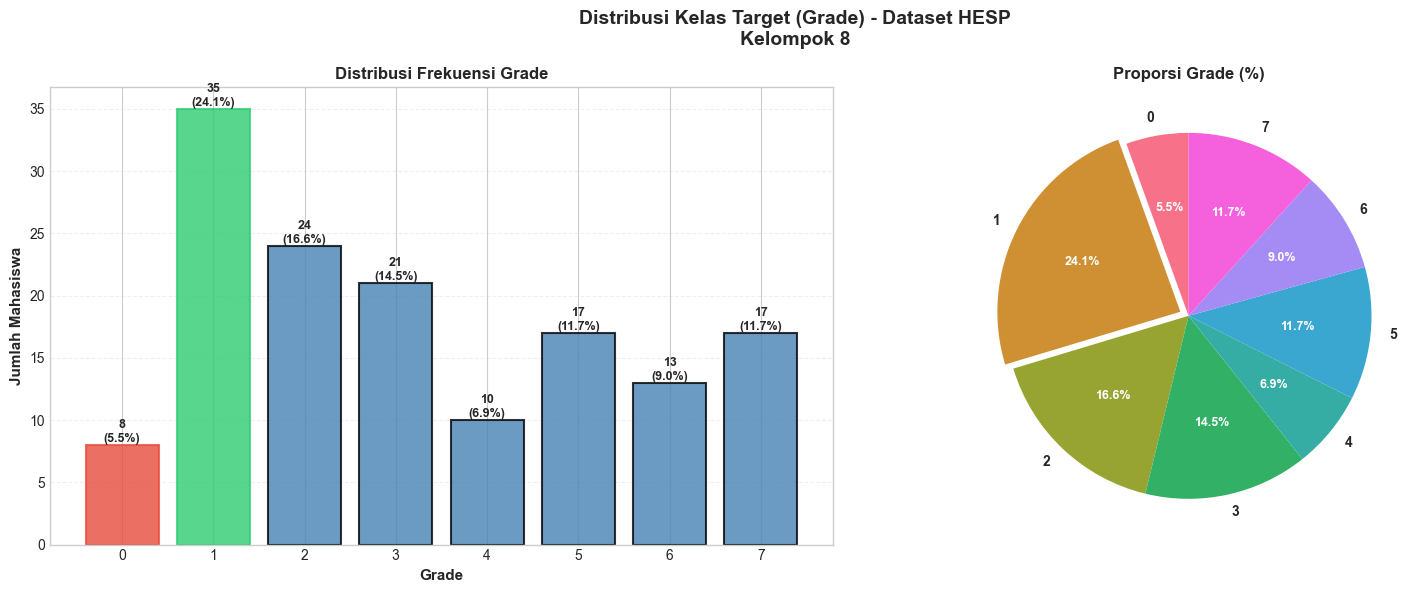

In [5]:
# ============================================================================
# 2.1 ANALISIS DISTRIBUSI TARGET (GRADE)
# ============================================================================

print("\n[2.1] Analisis Distribusi Target (Grade)")
print("-"*80)

# Hitung distribusi kelas
target_dist = df[target_col].value_counts().sort_index()
target_pct = (df[target_col].value_counts(normalize=True) * 100).sort_index()

print(f"\n📊 DISTRIBUSI KELAS '{target_col}':")
print("-"*80)
print(f"{'Grade':<10} {'Count':<10} {'Percentage':<12} {'Bar Chart'}")
print("-"*80)

for grade in target_dist.index:
    count = target_dist[grade]
    pct = target_pct[grade]
    bar = "█" * int(pct / 2)
    print(f"{grade:<10} {count:<10} {pct:<11.2f}% {bar}")

print("-"*80)
print(f"Total: {len(df)} mahasiswa")

# Analisis balance
max_class = target_dist.max()
min_class = target_dist.min()
imbalance_ratio = max_class / min_class

print(f"\n📈 ANALISIS BALANCE:")
print(f"   • Kelas terbanyak: {target_dist.idxmax()} ({max_class} sampel)")
print(f"   • Kelas tersedikit: {target_dist.idxmin()} ({min_class} sampel)")
print(f"   • Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print(f"   ⚠️  WARNING: Dataset SANGAT IMBALANCED!")
    print(f"      Pertimbangkan teknik handling imbalanced data:")
    print(f"      - SMOTE (Synthetic Minority Over-sampling)")
    print(f"      - Class weight adjustment")
    print(f"      - Stratified sampling")
elif imbalance_ratio > 1.5:
    print(f"   ⚠️  Dataset cukup imbalanced, perlu stratified split")
else:
    print(f"   ✅ Dataset cukup balanced")

# VISUALISASI 1: Bar Chart Distribusi Grade
print("\n📊 Membuat visualisasi distribusi grade...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribusi Kelas Target (Grade) - Dataset HESP\nKelompok 8', 
             fontsize=14, fontweight='bold')

# Subplot 1: Bar Chart
ax1 = axes[0]
bars = ax1.bar(range(len(target_dist)), target_dist.values, 
               color='steelblue', edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_xticks(range(len(target_dist)))
ax1.set_xticklabels(target_dist.index, rotation=0, ha='center')
ax1.set_xlabel('Grade', fontsize=11, fontweight='bold')
ax1.set_ylabel('Jumlah Mahasiswa', fontsize=11, fontweight='bold')
ax1.set_title('Distribusi Frekuensi Grade', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Tambahkan label nilai dan persentase di atas bar
for i, (bar, grade) in enumerate(zip(bars, target_dist.index)):
    height = bar.get_height()
    pct = target_pct[grade]
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({pct:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Highlight kelas dengan jumlah tertinggi dan terendah
bars[target_dist.values.argmax()].set_color('#2ecc71')  # Hijau untuk max
bars[target_dist.values.argmin()].set_color('#e74c3c')  # Merah untuk min

# Subplot 2: Pie Chart
ax2 = axes[1]
colors = sns.color_palette('husl', len(target_dist))
wedges, texts, autotexts = ax2.pie(target_dist.values, 
                                     labels=target_dist.index,
                                     autopct='%1.1f%%',
                                     colors=colors,
                                     startangle=90,
                                     explode=[0.05 if x == target_dist.max() else 0 for x in target_dist.values])

# Styling pie chart
for text in texts:
    text.set_fontsize(10)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

ax2.set_title('Proporsi Grade (%)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/01_distribusi_kelas.png', dpi=300, bbox_inches='tight')
print("✅ Visualisasi disimpan: ../results/figures/01_distribusi_kelas.png")
plt.show()


[2.2] Analisis Fitur Numerik
--------------------------------------------------------------------------------
✅ Ditemukan 32 kolom numerik:
    1. 1
    2. 2
    3. 3
    4. 4
    5. 5
    6. 6
    7. 7
    8. 8
    9. 9
   10. 10
   11. 11
   12. 12
   13. 13
   14. 14
   15. 15
   16. 16
   17. 17
   18. 18
   19. 19
   20. 20
   21. 21
   22. 22
   23. 23
   24. 24
   25. 25
   26. 26
   27. 27
   28. 28
   29. 29
   30. 30
   31. COURSE ID
   32. GRADE

📊 STATISTIK DESKRIPTIF EXTENDED:
             count   mean    std    min    25%    50%    75%    max  missing  \
1         145.0000 1.6207 0.6132 1.0000 1.0000 2.0000 2.0000 3.0000        0   
2         145.0000 1.6000 0.4916 1.0000 1.0000 2.0000 2.0000 2.0000        0   
3         145.0000 1.9448 0.5372 1.0000 2.0000 2.0000 2.0000 3.0000        0   
4         145.0000 3.5724 0.8058 1.0000 3.0000 3.0000 4.0000 5.0000        0   
5         145.0000 1.6621 0.4746 1.0000 1.0000 2.0000 2.0000 2.0000        0   
6         145.0000 1.600

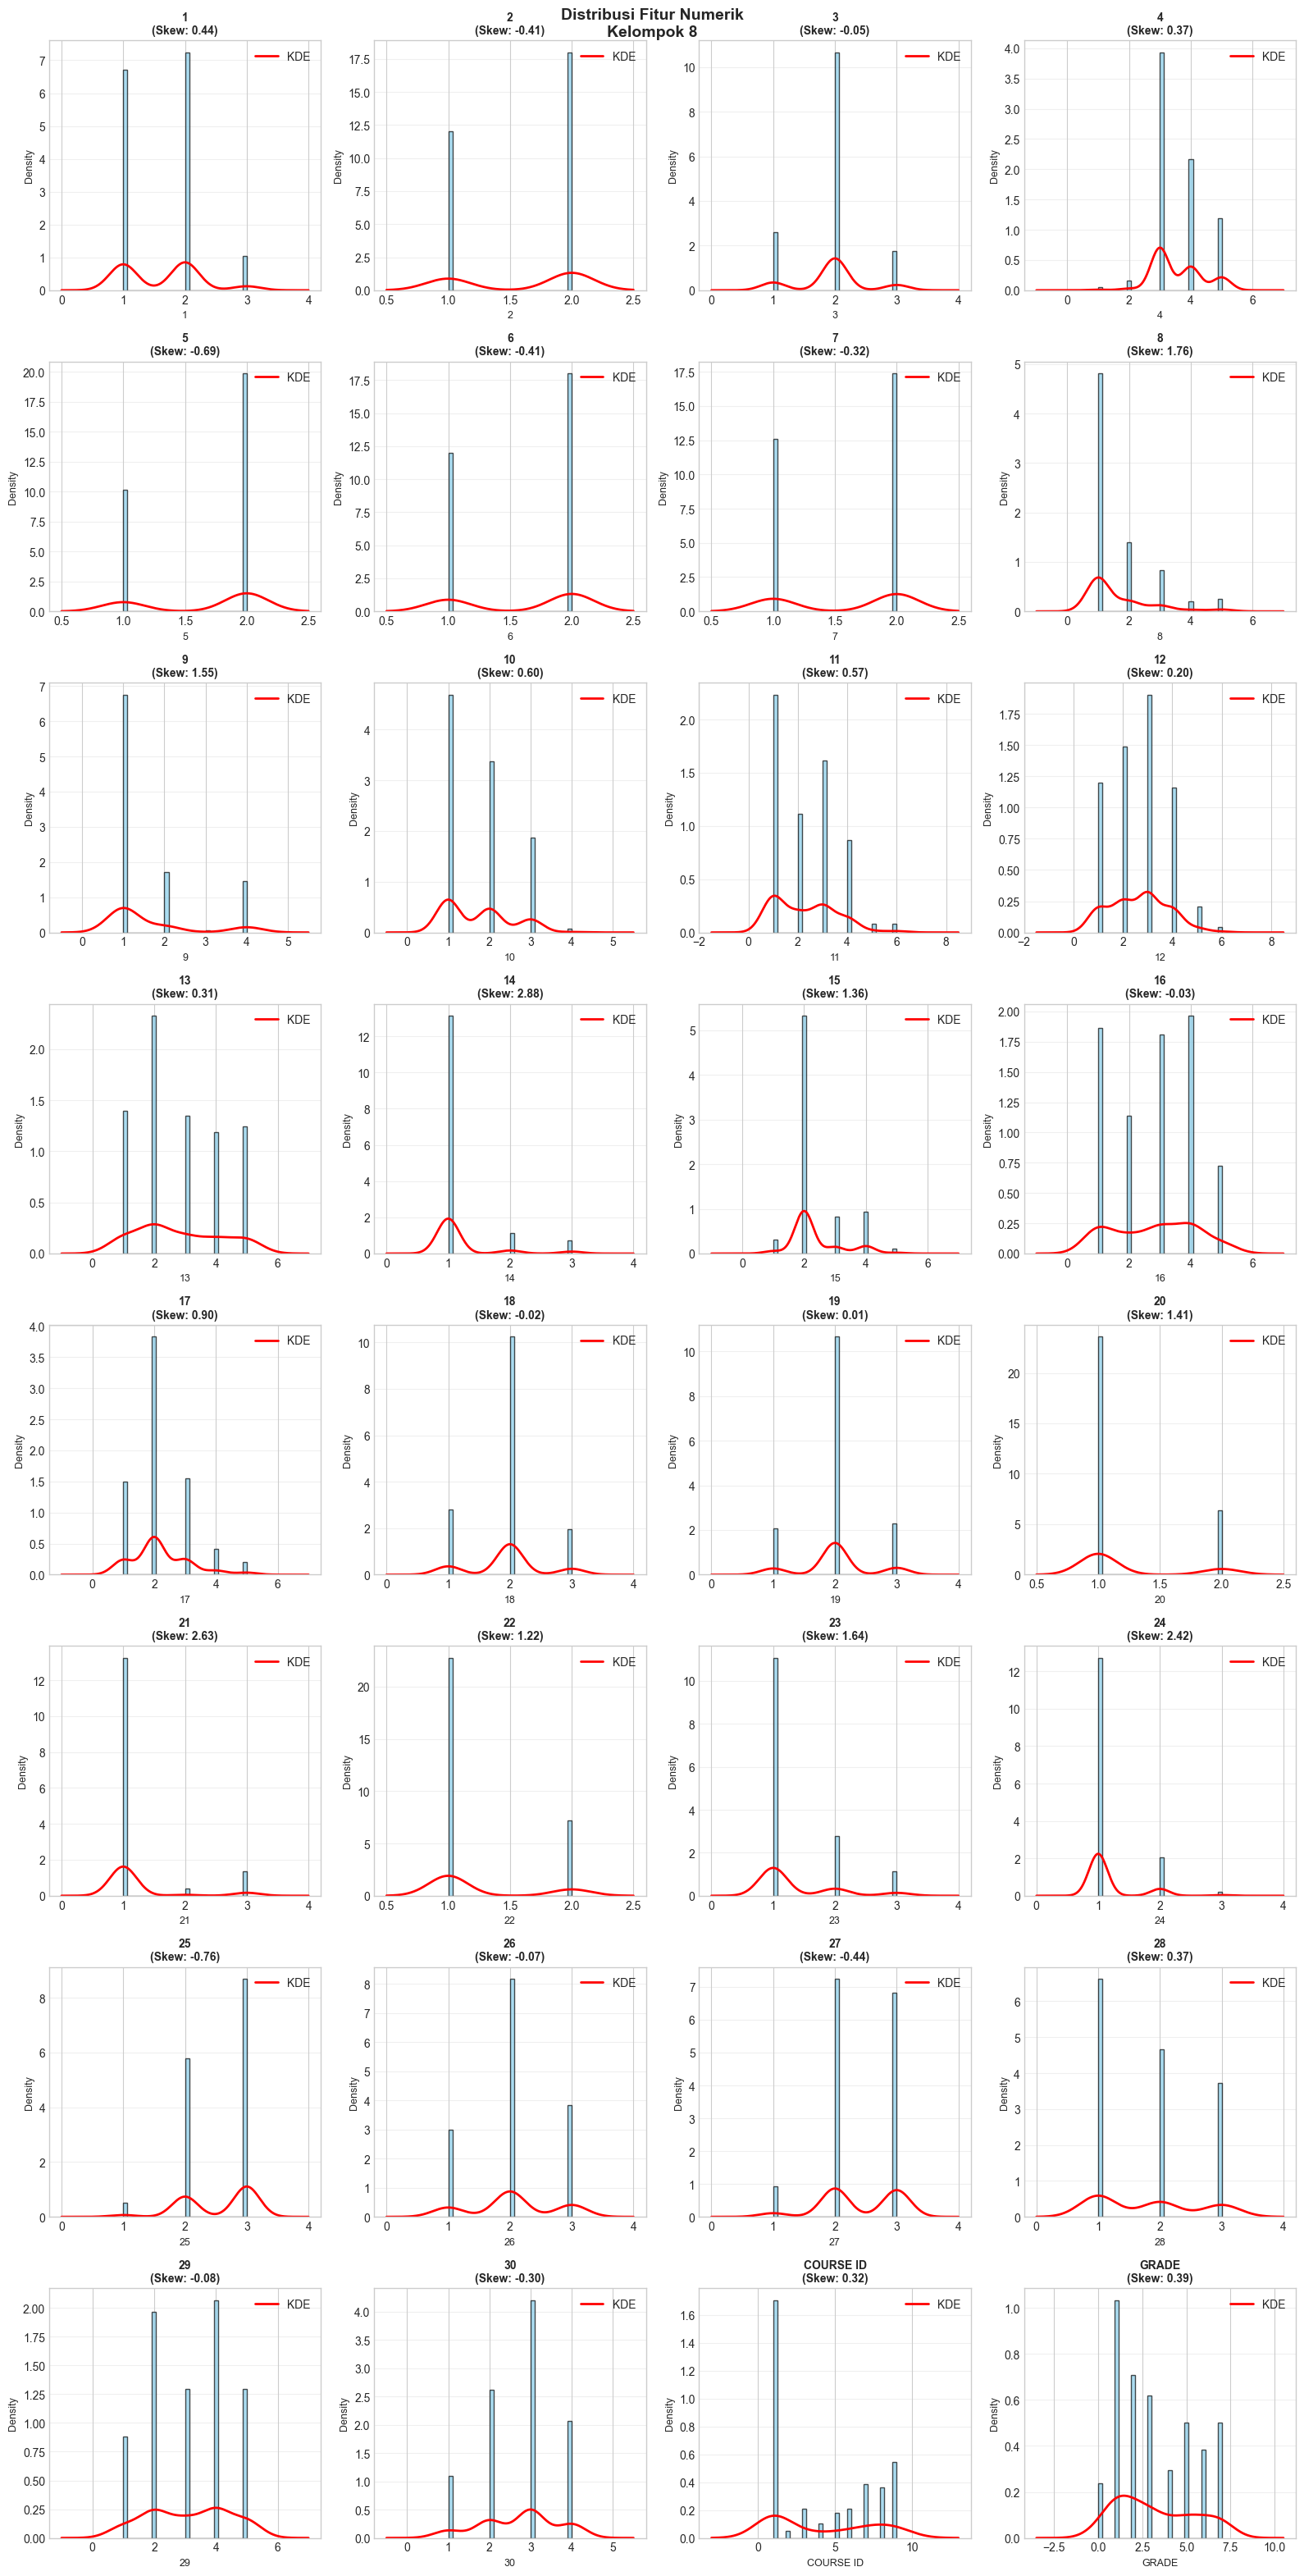

In [6]:
# ============================================================================
# 2.2 ANALISIS FITUR NUMERIK
# ============================================================================

print("\n[2.2] Analisis Fitur Numerik")
print("-"*80)

# Identifikasi kolom numerik
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) == 0:
    print("⚠️  Tidak ada kolom numerik untuk dianalisis")
else:
    print(f"✅ Ditemukan {len(numeric_cols)} kolom numerik:")
    for i, col in enumerate(numeric_cols, 1):
        print(f"   {i:2d}. {col}")
    
    # Statistik deskriptif extended
    print(f"\n📊 STATISTIK DESKRIPTIF EXTENDED:")
    stats_extended = df[numeric_cols].describe().T
    stats_extended['missing'] = df[numeric_cols].isnull().sum()
    stats_extended['skewness'] = df[numeric_cols].skew()
    stats_extended['kurtosis'] = df[numeric_cols].kurtosis()
    print(stats_extended)
    
    # Interpretasi skewness
    print(f"\n📈 INTERPRETASI SKEWNESS:")
    for col in numeric_cols:
        skew = df[col].skew()
        if abs(skew) < 0.5:
            interpretation = "Distribusi cukup simetris ✅"
        elif abs(skew) < 1:
            interpretation = "Distribusi cukup skewed ⚠️"
        else:
            interpretation = "Distribusi sangat skewed ❌"
        print(f"   • {col:<30}: {skew:>7.3f} → {interpretation}")
    
    # VISUALISASI 2: Distribusi Fitur Numerik
    if len(numeric_cols) > 0:
        print("\n📊 Membuat visualisasi distribusi fitur numerik...")
        
        n_cols = min(len(numeric_cols), 4)
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
        fig.suptitle('Distribusi Fitur Numerik\nKelompok 8', 
                     fontsize=14, fontweight='bold')
        
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, col in enumerate(numeric_cols):
            row = idx // n_cols
            col_idx = idx % n_cols
            ax = axes[row, col_idx]
            
            # Histogram dengan KDE
            ax.hist(df[col].dropna(), bins=30, color='skyblue', 
                   edgecolor='black', alpha=0.7, density=True)
            
            # Tambahkan KDE curve
            df[col].dropna().plot(kind='kde', ax=ax, color='red', 
                                 linewidth=2, label='KDE')
            
            ax.set_xlabel(col, fontsize=9)
            ax.set_ylabel('Density', fontsize=9)
            ax.set_title(f'{col}\n(Skew: {df[col].skew():.2f})', 
                        fontsize=10, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)
            ax.legend()
        
        # Sembunyikan subplot yang tidak terpakai
        for idx in range(len(numeric_cols), n_rows * n_cols):
            row = idx // n_cols
            col_idx = idx % n_cols
            axes[row, col_idx].axis('off')
        
        plt.tight_layout()
        plt.savefig('../results/figures/02_distribusi_numerik.png', dpi=300, bbox_inches='tight')
        print("✅ Visualisasi disimpan: ../results/figures/02_distribusi_numerik.png")
        plt.show()


[2.3] Analisis Korelasi Antar Fitur
--------------------------------------------------------------------------------
📊 Menghitung correlation matrix untuk 32 fitur...
✅ Heatmap korelasi disimpan: ../results/figures/03_correlation_matrix.png


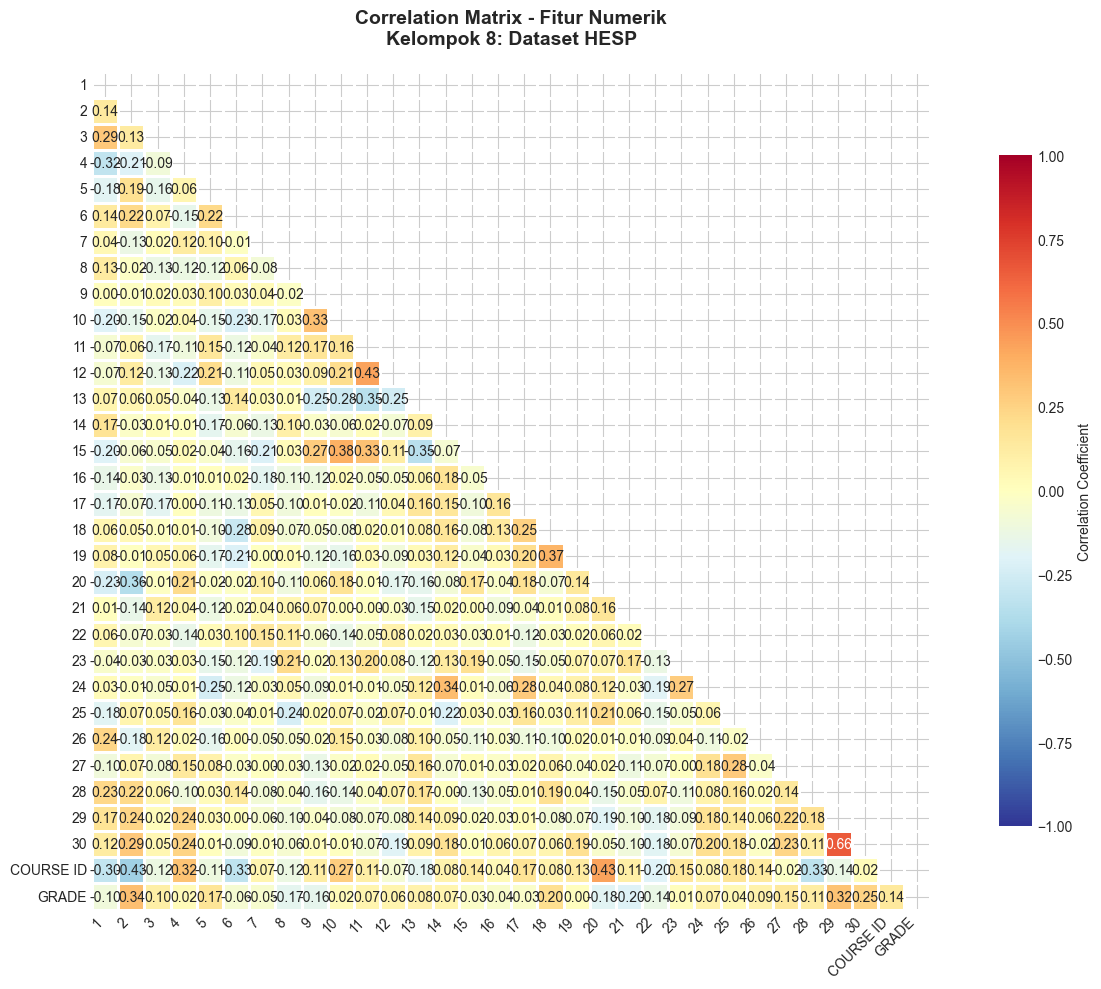


🔝 TOP 10 KORELASI TERTINGGI (Antar Fitur):
--------------------------------------------------------------------------------
Rank   Fitur 1                   Fitur 2                   Correlation  Strength
--------------------------------------------------------------------------------
1      29                        30                             0.658  Kuat
2      COURSE ID                 20                             0.435  Sedang
3      2                         COURSE ID                     -0.431  Sedang
4      12                        11                             0.430  Sedang
5      10                        15                             0.385  Sedang
6      18                        19                             0.368  Sedang
7      2                         20                            -0.364  Sedang
8      13                        11                            -0.351  Sedang
9      13                        15                            -0.348  Sedang
10     14    

In [7]:
# ============================================================================
# 2.3 ANALISIS KORELASI ANTAR FITUR
# ============================================================================

print("\n[2.3] Analisis Korelasi Antar Fitur")
print("-"*80)

if len(numeric_cols) > 1:
    print(f"📊 Menghitung correlation matrix untuk {len(numeric_cols)} fitur...")
    
    # Hitung correlation matrix
    correlation_matrix = df[numeric_cols].corr()
    
    # VISUALISASI 3: Heatmap Korelasi
    plt.figure(figsize=(14, 10))
    
    # Buat mask untuk upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt='.2f',
                cmap='RdYlBu_r',
                center=0,
                square=True,
                linewidths=1,
                cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
                vmin=-1, vmax=1)
    
    plt.title('Correlation Matrix - Fitur Numerik\nKelompok 8: Dataset HESP', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('../results/figures/03_correlation_matrix.png', dpi=300, bbox_inches='tight')
    print("✅ Heatmap korelasi disimpan: ../results/figures/03_correlation_matrix.png")
    plt.show()
    
    # Analisis korelasi tertinggi
    print(f"\n🔝 TOP 10 KORELASI TERTINGGI (Antar Fitur):")
    print("-"*80)
    
    # Ambil korelasi pairs (exclude diagonal dan duplikat)
    corr_pairs = correlation_matrix.abs().unstack()
    corr_pairs = corr_pairs[corr_pairs < 1].sort_values(ascending=False)
    
    # Hapus duplikat
    seen = set()
    unique_pairs = []
    for (var1, var2), corr in corr_pairs.items():
        pair = tuple(sorted([var1, var2]))
        if pair not in seen:
            seen.add(pair)
            unique_pairs.append(((var1, var2), corr))
    
    print(f"{'Rank':<6} {'Fitur 1':<25} {'Fitur 2':<25} {'Correlation':<12} {'Strength'}")
    print("-"*80)
    
    for i, ((var1, var2), corr) in enumerate(unique_pairs[:10], 1):
        if corr >= 0.7:
            strength = "Sangat Kuat ⚠️"
        elif corr >= 0.5:
            strength = "Kuat"
        elif corr >= 0.3:
            strength = "Sedang"
        else:
            strength = "Lemah"
        
        # Ambil correlation asli (dengan tanda)
        actual_corr = correlation_matrix.loc[var1, var2]
        print(f"{i:<6} {var1:<25} {var2:<25} {actual_corr:>10.3f}  {strength}")
    
    # Warning untuk multicollinearity
    high_corr_pairs = [pair for pair, corr in unique_pairs if corr >= 0.8]
    if high_corr_pairs:
        print(f"\n⚠️  WARNING: Ditemukan {len(high_corr_pairs)} pasangan fitur dengan korelasi sangat tinggi (>0.8)")
        print("   Pertimbangkan untuk:")
        print("   - Feature selection")
        print("   - PCA (Principal Component Analysis)")
        print("   - Remove redundant features")
    else:
        print(f"\n✅ Tidak ada multicollinearity yang signifikan")

else:
    print("⚠️  Tidak cukup fitur numerik untuk analisis korelasi (minimum 2 fitur)")


[2.4] Analisis Fitur Kategorik
--------------------------------------------------------------------------------
✅ Ditemukan 1 kolom kategorik:

No    Nama Kolom                     Unique Values   Top Value           
--------------------------------------------------------------------------------
1     STUDENT ID                     145             STUDENT1            

📊 Membuat visualisasi untuk 1 fitur kategorik...
✅ Visualisasi disimpan: ../results/figures/04_distribusi_kategorik.png


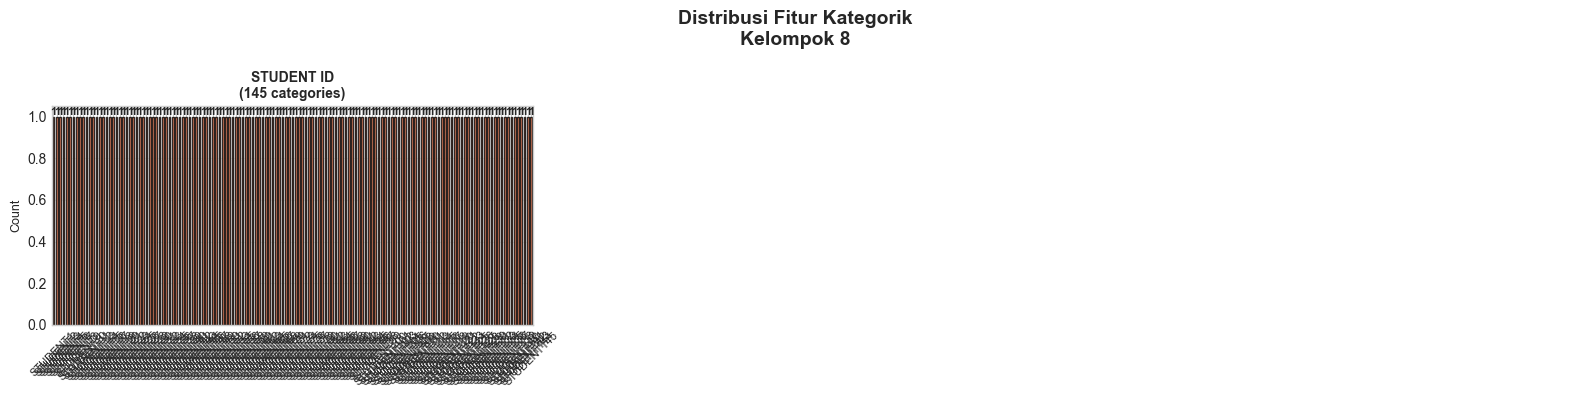

In [8]:
#============================================================================
# 2.4 ANALISIS FITUR KATEGORIK
# ============================================================================

print("\n[2.4] Analisis Fitur Kategorik")
print("-"*80)

# Identifikasi kolom kategorik
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Exclude target dari list jika masih termasuk
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

if len(categorical_cols) == 0:
    print("⚠️  Tidak ada kolom kategorik untuk dianalisis (selain target)")
else:
    print(f"✅ Ditemukan {len(categorical_cols)} kolom kategorik:")
    
    print(f"\n{'No':<5} {'Nama Kolom':<30} {'Unique Values':<15} {'Top Value':<20}")
    print("-"*80)
    
    for i, col in enumerate(categorical_cols, 1):
        n_unique = df[col].nunique()
        top_value = df[col].mode()[0] if len(df[col].mode()) > 0 else "N/A"
        top_count = df[col].value_counts().iloc[0] if len(df[col]) > 0 else 0
        print(f"{i:<5} {col:<30} {n_unique:<15} {str(top_value):<20}")
    
    # VISUALISASI 4: Distribusi Fitur Kategorik (Top N)
    # Pilih max 6 kolom kategorik untuk visualisasi
    cols_to_plot = categorical_cols[:6]
    
    if len(cols_to_plot) > 0:
        print(f"\n📊 Membuat visualisasi untuk {len(cols_to_plot)} fitur kategorik...")
        
        n_cols = 3
        n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
        fig.suptitle('Distribusi Fitur Kategorik\nKelompok 8', 
                     fontsize=14, fontweight='bold')
        
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, col in enumerate(cols_to_plot):
            row = idx // n_cols
            col_idx = idx % n_cols
            ax = axes[row, col_idx]
            
            # Value counts
            value_counts = df[col].value_counts()
            
            # Bar plot
            value_counts.plot(kind='bar', ax=ax, color='coral', 
                            edgecolor='black', alpha=0.8)
            ax.set_title(f'{col}\n({value_counts.shape[0]} categories)', 
                        fontsize=10, fontweight='bold')
            ax.set_xlabel('')
            ax.set_ylabel('Count', fontsize=9)
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            ax.grid(axis='y', alpha=0.3)
            
            # Tambahkan nilai di atas bar
            for i, v in enumerate(value_counts.values):
                ax.text(i, v, str(v), ha='center', va='bottom', 
                       fontweight='bold', fontsize=8)
        
        # Sembunyikan subplot kosong
        for idx in range(len(cols_to_plot), n_rows * n_cols):
            row = idx // n_cols
            col_idx = idx % n_cols
            axes[row, col_idx].axis('off')
        
        plt.tight_layout()
        plt.savefig('../results/figures/04_distribusi_kategorik.png', dpi=300, bbox_inches='tight')
        print("✅ Visualisasi disimpan: ../results/figures/04_distribusi_kategorik.png")
        plt.show()


[2.5] Analisis Hubungan Fitur vs Target
--------------------------------------------------------------------------------
📊 Membuat boxplot fitur numerik vs target grade...
✅ Visualisasi disimpan: ../results/figures/05_numerik_vs_grade.png


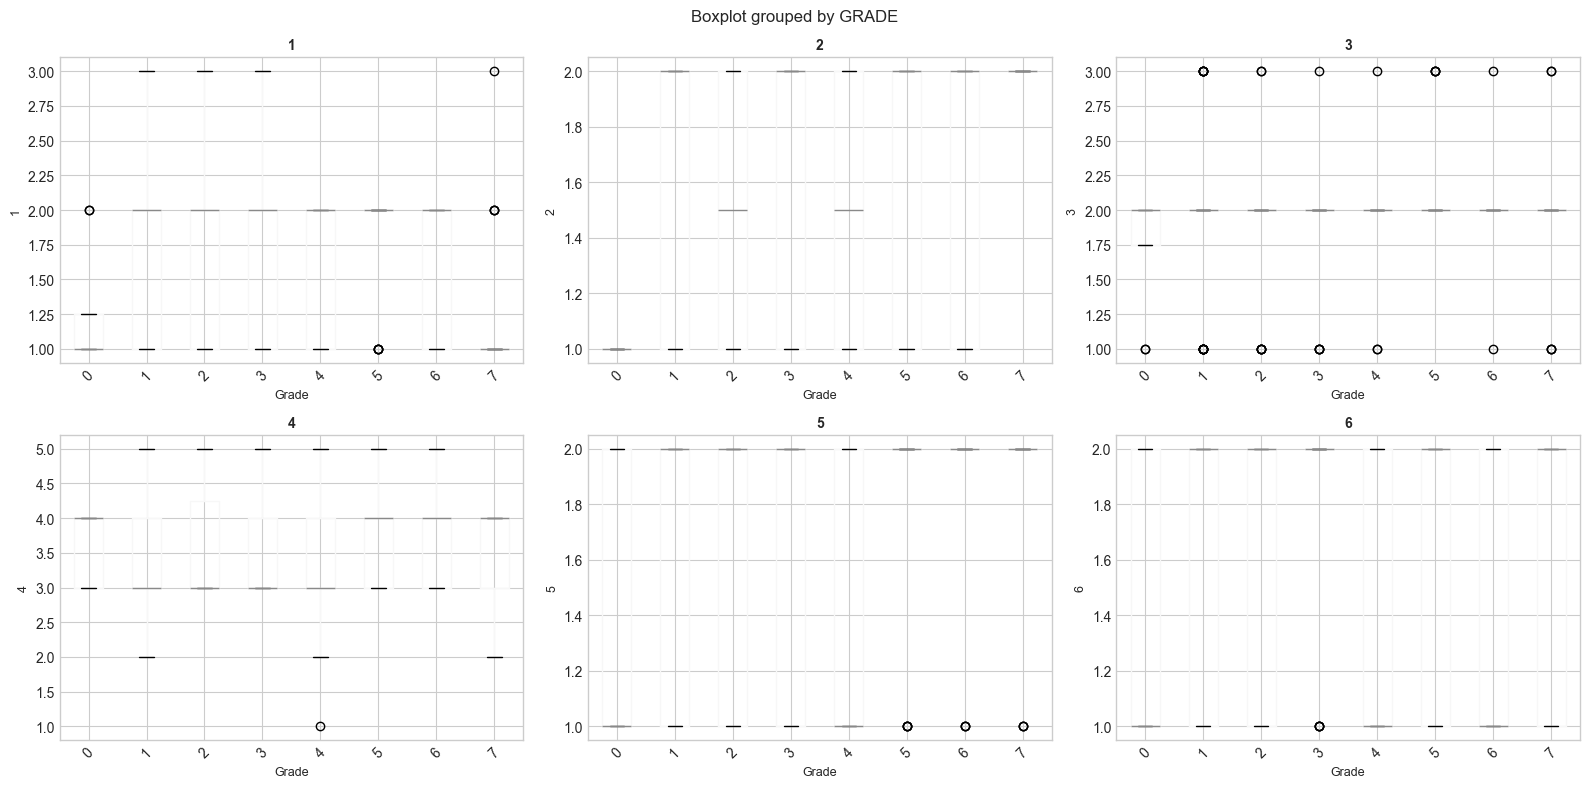

In [9]:
# ============================================================================
# 2.5 ANALISIS HUBUNGAN FITUR VS TARGET
# ============================================================================

print("\n[2.5] Analisis Hubungan Fitur vs Target")
print("-"*80)

# Untuk fitur numerik: Boxplot per grade
if len(numeric_cols) > 0:
    print(f"📊 Membuat boxplot fitur numerik vs target grade...")
    
    # Pilih beberapa fitur numerik untuk visualisasi
    cols_to_plot = numeric_cols[:6]
    
    n_cols = 3
    n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    fig.suptitle(f'Distribusi Fitur Numerik per Grade\nKelompok 8', 
                 fontsize=14, fontweight='bold')
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, col in enumerate(cols_to_plot):
        row = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row, col_idx]
        
        # Boxplot
        df.boxplot(column=col, by=target_col, ax=ax)
        ax.set_title(col, fontsize=10, fontweight='bold')
        ax.set_xlabel('Grade', fontsize=9)
        ax.set_ylabel(col, fontsize=9)
        plt.sca(ax)
        plt.xticks(rotation=45)
    
    # Sembunyikan subplot kosong
    for idx in range(len(cols_to_plot), n_rows * n_cols):
        row = idx // n_cols
        col_idx = idx % n_cols
        axes[row, col_idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/figures/05_numerik_vs_grade.png', dpi=300, bbox_inches='tight')
    print("✅ Visualisasi disimpan: ../results/figures/05_numerik_vs_grade.png")
    plt.show()


In [10]:
# ============================================================================
# 2.6 DETEKSI OUTLIERS
# ============================================================================

print("\n[2.6] Deteksi Outliers (Fitur Numerik)")
print("-"*80)

if len(numeric_cols) > 0:
    print(f"🔍 Mendeteksi outliers menggunakan metode IQR...")
    
    outlier_summary = []
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        n_outliers = len(outliers)
        pct_outliers = (n_outliers / len(df)) * 100
        
        outlier_summary.append({
            'Fitur': col,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'N Outliers': n_outliers,
            'Pct Outliers': pct_outliers
        })
    
    outlier_df = pd.DataFrame(outlier_summary)
    print(outlier_df.to_string(index=False))
    
    total_outliers = outlier_df['N Outliers'].sum()
    if total_outliers > 0:
        print(f"\n⚠️  Total outliers terdeteksi: {total_outliers}")
        print("   Pertimbangkan untuk:")
        print("   - Capping outliers")
        print("   - Transformasi data (log, sqrt)")
        print("   - Menggunakan robust scaler")
    else:
        print(f"\n✅ Tidak ada outliers signifikan terdeteksi")




[2.6] Deteksi Outliers (Fitur Numerik)
--------------------------------------------------------------------------------
🔍 Mendeteksi outliers menggunakan metode IQR...
    Fitur     Q1     Q3    IQR  Lower Bound  Upper Bound  N Outliers  Pct Outliers
        1 1.0000 2.0000 1.0000      -0.5000       3.5000           0        0.0000
        2 1.0000 2.0000 1.0000      -0.5000       3.5000           0        0.0000
        3 2.0000 2.0000 0.0000       2.0000       2.0000          42       28.9655
        4 3.0000 4.0000 1.0000       1.5000       5.5000           1        0.6897
        5 1.0000 2.0000 1.0000      -0.5000       3.5000           0        0.0000
        6 1.0000 2.0000 1.0000      -0.5000       3.5000           0        0.0000
        7 1.0000 2.0000 1.0000      -0.5000       3.5000           0        0.0000
        8 1.0000 2.0000 1.0000      -0.5000       3.5000           9        6.2069
        9 1.0000 2.0000 1.0000      -0.5000       3.5000          21       14.4828
 

In [11]:
# ============================================================================
# 2.7 SAVE EDA SUMMARY
# ============================================================================

print("\n[2.7] Save EDA Summary")
print("-"*80)

# Buat comprehensive report
summary_path = '../results/reports/02_EDA_summary.txt'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write(" EDA SUMMARY - TAHAP 2 ".center(80, "=") + "\n")
    f.write("="*80 + "\n\n")
    f.write("Kelompok 8: Rahma Fitria Tunnisa & Rahmawati\n")
    f.write("Dataset: Higher Education Students Performance Evaluation\n\n")
    
    f.write("1. DISTRIBUSI TARGET\n")
    f.write("-"*80 + "\n")
    f.write(f"Target column: {target_col}\n")
    f.write(f"Number of classes: {len(target_dist)}\n")
    f.write(f"Classes: {', '.join(map(str, target_dist.index))}\n")
    f.write(f"Imbalance ratio: {imbalance_ratio:.2f}:1\n\n")
    
    f.write("Distribution:\n")
    for grade in target_dist.index:
        f.write(f"  {grade}: {target_dist[grade]} ({target_pct[grade]:.2f}%)\n")
    
    f.write("\n2. FITUR NUMERIK\n")
    f.write("-"*80 + "\n")
    f.write(f"Total: {len(numeric_cols)} kolom\n")
    f.write(f"Kolom: {', '.join(numeric_cols)}\n\n")
    
    f.write("\n3. FITUR KATEGORIK\n")
    f.write("-"*80 + "\n")
    f.write(f"Total: {len(categorical_cols)} kolom\n")
    if len(categorical_cols) > 0:
        f.write(f"Kolom: {', '.join(categorical_cols)}\n")
    
    f.write("\n4. OUTLIERS\n")
    f.write("-"*80 + "\n")
    f.write(f"Total outliers: {total_outliers if len(numeric_cols) > 0 else 0}\n")
    
    f.write("\n5. VISUALISASI YANG DIHASILKAN\n")
    f.write("-"*80 + "\n")
    f.write("  • results/figures/01_distribusi_kelas.png\n")
    f.write("  • results/figures/02_distribusi_numerik.png\n")
    f.write("  • results/figures/03_correlation_matrix.png\n")
    f.write("  • results/figures/04_distribusi_kategorik.png\n")
    f.write("  • results/figures/05_numerik_vs_grade.png\n")

print(f"✅ EDA summary disimpan: {summary_path}")


[2.7] Save EDA Summary
--------------------------------------------------------------------------------
✅ EDA summary disimpan: ../results/reports/02_EDA_summary.txt


In [12]:
# ============================================================================
# RINGKASAN TAHAP 2
# ============================================================================

print("\n" + "="*80)
print(" ✅ TAHAP 2 SELESAI ".center(80, "="))
print("="*80)

print("\n📌 RINGKASAN EDA:")
print(f"   ✓ Target: {len(target_dist)} kelas, imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"   ✓ Fitur numerik: {len(numeric_cols)} kolom")
print(f"   ✓ Fitur kategorik: {len(categorical_cols)} kolom")
if len(numeric_cols) > 0:
    print(f"   ✓ Outliers: {total_outliers} terdeteksi")
print(f"   ✓ Visualisasi: 5 grafik tersimpan")

print("\n💡 KEY INSIGHTS:")
if imbalance_ratio > 3:
    print("   ⚠️  Dataset sangat imbalanced → perlu stratified split & class weights")
if len(numeric_cols) > 0 and len([pair for pair, corr in unique_pairs if corr >= 0.8]) > 0:
    print("   ⚠️  Ada multicollinearity → pertimbangkan feature selection")
if len(numeric_cols) > 0 and total_outliers > 0:
    print("   ⚠️  Ada outliers → pertimbangkan robust scaling")

print("\n🎯 LANGKAH SELANJUTNYA:")
print("   → Lanjut ke TAHAP 3: Data Preprocessing")
print("   → Handling imbalanced class")
print("   → Feature encoding & scaling")

print("\n" + "="*80)
print("✅ SIAP UNTUK TAHAP 3!")


============================== ✅ TAHAP 2 SELESAI ===============================

📌 RINGKASAN EDA:
   ✓ Target: 8 kelas, imbalance ratio: 4.38:1
   ✓ Fitur numerik: 32 kolom
   ✓ Fitur kategorik: 1 kolom
   ✓ Outliers: 337 terdeteksi
   ✓ Visualisasi: 5 grafik tersimpan

💡 KEY INSIGHTS:
   ⚠️  Dataset sangat imbalanced → perlu stratified split & class weights
   ⚠️  Ada outliers → pertimbangkan robust scaling

🎯 LANGKAH SELANJUTNYA:
   → Lanjut ke TAHAP 3: Data Preprocessing
   → Handling imbalanced class
   → Feature encoding & scaling

✅ SIAP UNTUK TAHAP 3!
